# 0. 미션 목표

이번 미션의 최종 목표는 **가장 정확한 분류 모델을 개발하여 고객이 정기 예금을 가입할지 여부를 예측**하고, 

그 모델을 통해 도출한 인사이트를 바탕으로 **비즈니스 전략을 제시**하는 것입니다.

**-> 이번 미션은 모델 학습 후 나온 결과로 데이터 분석**

### 강사님이 주신 가이드라인

1. 데이터 탐색 (EDA)
데이터의 구조와 통계적 특성을 가장 먼저 확인합니다.

- 구조 파악: .info(), .head()
- 통계 요약: .describe()

2. 데이터 전처리 (Preprocessing) - 모델의 성능을 결정짓는 가장 중요한 단계입니다.

- 분포 확인: .hist()를 통한 시각화 및 데이터 왜도(Skewness) 체크
- 결측치/중복치: Missing Value 처리 및 중복 데이터 제거
- 이상치(Outlier): 데이터 범위를 벗어난 값 처리
- 목표변수 불균형 확인: y값의 불균형 정도 확인 및 리샘플링(SMOTE, SMOTETomek)
- 스케일링: 숫자형 데이터 표준화(Standardization)
- 인코딩: 범주형 데이터 원-핫 인코딩(One-Hot Encoding)
- 데이터 분할: train_df를 8:2 비율로 학습/평가용 분리

3. 모델 학습 및 최적화 - 다양한 알고리즘을 적용하고 최상의 파라미터를 찾습니다.

- 선형 모델: 다중 선형 회귀, Lasso(L1), Ridge(L2)
- 비선형 모델: 다항 회귀 (Polynomial Regression)
- 트리/앙상블: Decision Tree, Random Forest, XGBoost, CatBoost, LGBM
- 하이퍼파라미터 튜닝: GridSearchCV 또는 Optuna 활용

4. 평가 및 최종 제출
- 평가지표: accuracy, precision, recall, f1-score, auc-roc, confusion matrix
- 최종 예측: 최적 모델로 속성 중요도를 살펴보고, 정기예금 마케팅 개선 방안 작성
- 결과 도출:  정기예금 마케팅 개선방안 제출

### 데이터 컬럼 설명

| 컬럼명 | 설명 |
|---|---|
| age | 나이 (숫자) |
| job | 직업 (범주형) |
| marital | 결혼 여부 (범주형) |
| education | 교육 수준 (범주형) |
| default | 신용 불량 여부 (범주형) |
| housing | 주택 대출 여부 (범주형) |
| loan | 개인 대출 여부 (범주형) |
| contact | 연락 유형 (범주형) |
| month | 마지막 연락 월 (범주형) |
| day_of_week | 마지막 연락 요일 (범주형) |
| duration | 마지막 연락 지속 시간 (초, 숫자) |
| campaign | 캠페인 동안 연락 횟수 (숫자) |
| pdays | 이전 캠페인 후 지난 일수 (숫자) |
| previous | 이전 캠페인 동안 연락 횟수 (숫자) |
| poutcome | 이전 캠페인의 결과 (범주형) |
| emp.var.rate | 고용 변동률 (숫자) |
| cons.price.idx | 소비자 물가지수 (숫자) |
| cons.conf.idx | 소비자 신뢰지수 (숫자) |
| euribor3m | 3개월 유리보 금리 (숫자) |
| nr.employed | 고용자 수 (숫자) |
| y | 정기 예금 가입 여부 (`yes` / `no`) |




# 1. EDA 및 전처리

In [1]:
# 필요한 라이브러리 불러오기
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from sklearn.metrics import root_mean_squared_error, accuracy_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

# 경고 안보이게 하기
import warnings
from scipy.linalg import LinAlgWarning
warnings.filterwarnings("ignore", category=LinAlgWarning)

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

c:\Users\wina0\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 데이터 불러오기
bank_df = pd.read_csv("bank-additional-full.csv", sep=";")

In [3]:
# 기본 정보 확인
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# 기본 정보 확인
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
# 기본 정보 확인
bank_df.describe(include='all')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188,41188,41188,41188,41188,41188,41188,41188,41188,...,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,...,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,NaN,36548
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.567593,962.475454,0.172963,NaN,0.081886,93.575664,-40.502600,3.621291,5167.035911,NaN
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.770014,186.910907,0.494901,NaN,1.570960,0.578840,4.628198,1.734447,72.251528,NaN
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,NaN
25%,32.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.344000,5099.100000,NaN
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


#### 1. 결측값 확인 및 처리

In [6]:
# 결측값 확인

bank_df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [7]:
# unknown 값 확인
(bank_df == 'unknown').sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

unknown은 하나의 범주로 데이터 분석할때 필요시 다른 범주로 해석 예정.

#### 2. 중복값 확인 및 처리

In [8]:
# 중복값 확인
bank_df[bank_df.duplicated(keep='first')]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20216,55,services,married,high.school,unknown,no,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


데이터별 고유 식별 번호는 없지만, 모든 속성이 동일하고, 특히 duration은 통화한 시간(초 단위)인데, 

모든 정보가 동일한 둘 이상의 사람이 같은 달, 같은 요일에 통화한 시간까지 같다고 보기는 어렵다.

고로 중복값으로 판단하여 제거.

In [9]:
# 중복값 제거
bank_df = bank_df.drop_duplicates(keep='first')

In [10]:
# 중복값 제거 후 재확인
bank_df[bank_df.duplicated(keep='first')]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y


## 3. 이상치 확인 및 처리

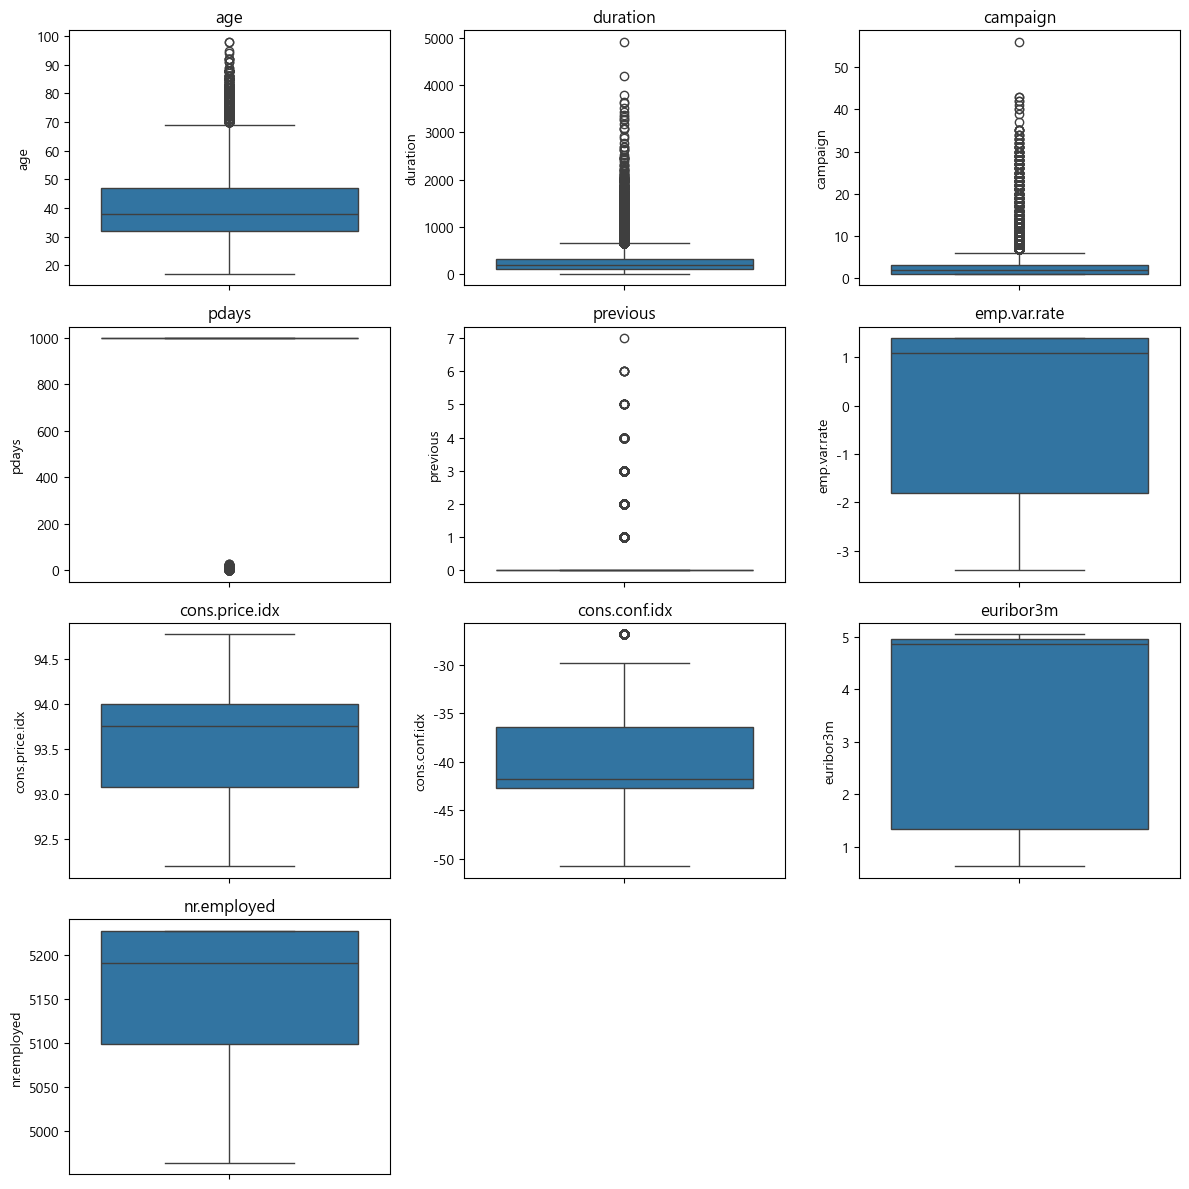

In [11]:
# 수치형 데이터 
numeric_cols = bank_df.select_dtypes(include='number').columns

cols = 3
rows = math.ceil(len(numeric_cols) / cols)

plt.figure(figsize=(cols * 4, rows * 3))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(y=bank_df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

이상치로 보이는 데이터가 일부 있으나, 전처리 하면서 판단 예정

## 4. 수치형 데이터

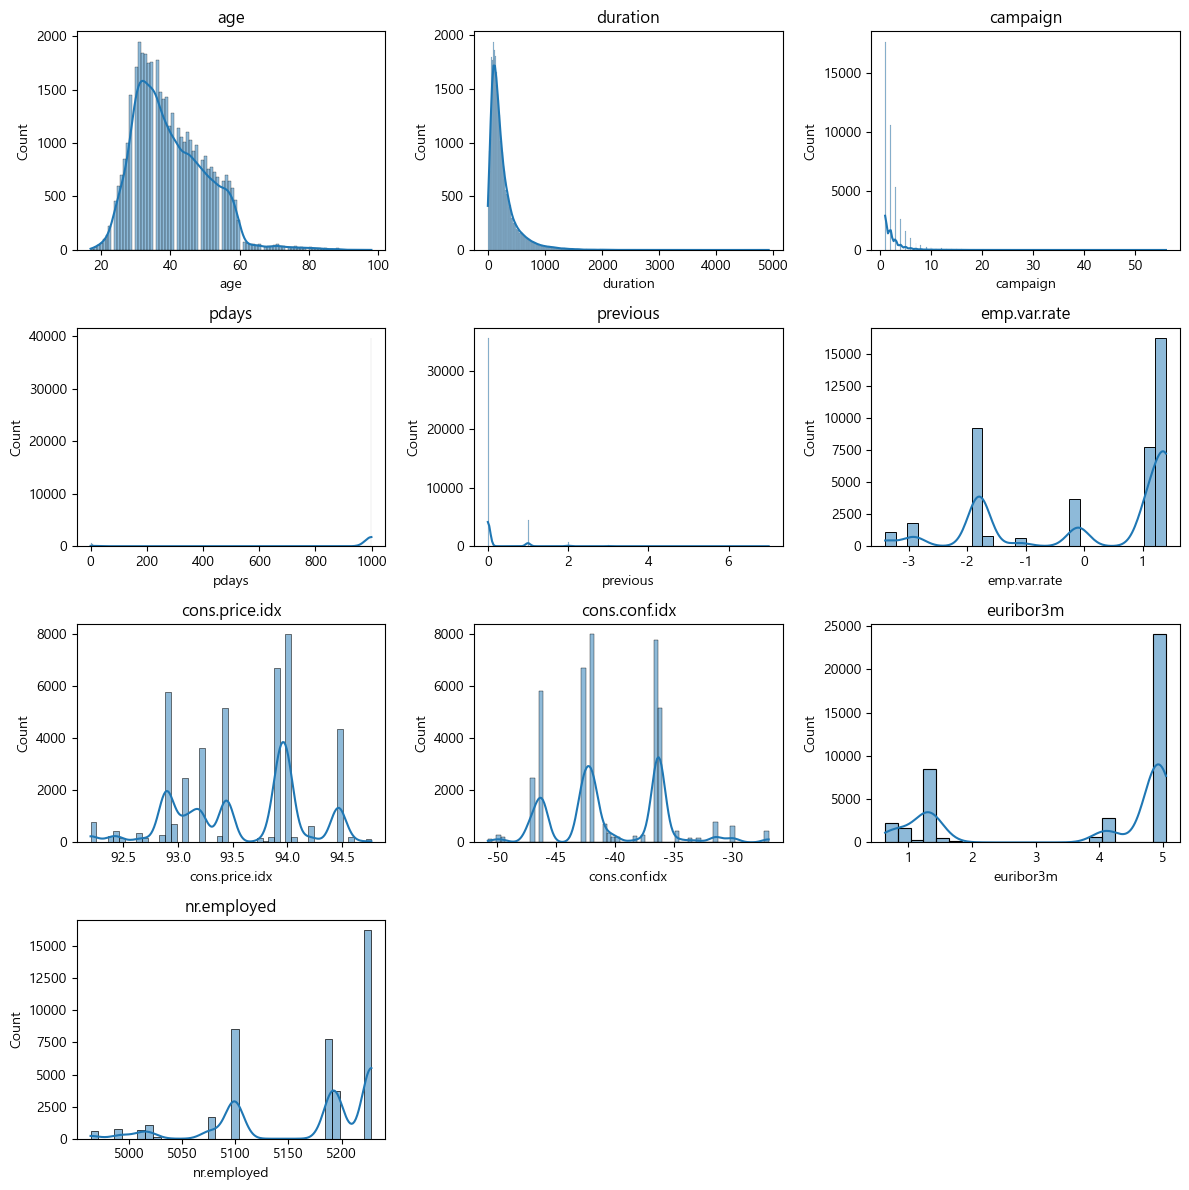

In [12]:
# histplot subplot 시각화
n = len(numeric_cols)
cols = 3                      
rows = math.ceil(n / cols)

plt.figure(figsize=(cols*4, rows*3))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(bank_df[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

age은 한쪽으로 치우쳐져 있어서 로그 변환

duration은 duration은 통화 종료 후 알수 있는 내용이라 예측 시점이 달라 학습 제외

그래프가 이상한 campaign, pdays, previous은 재확인


#### - age

In [13]:
bank_df['age_log']= np.log1p(bank_df['age'])

bank_df[['age_log']]

,age_log
0,4.043051
1,4.060443
2,3.637586
3,3.713572
4,4.043051
...,...
41183,4.304065
41184,3.850148
41185,4.043051
41186,3.806662


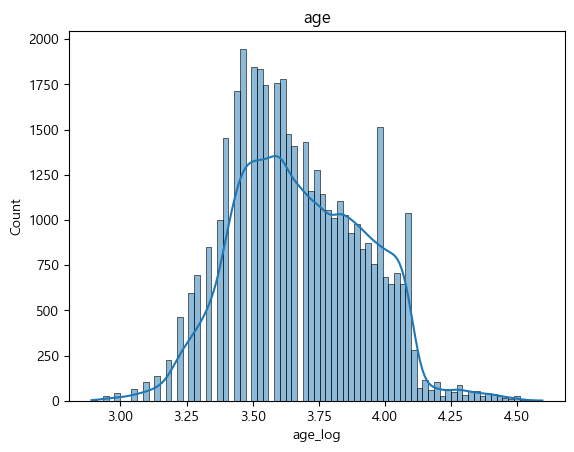

In [14]:
# 변환 확인

sns.histplot(bank_df['age_log'], kde=True)
plt.title('age')
plt.show()

#### - duration

duration은 통화 종료 후 알수 있는 내용이라 예측 시점이 달라 학습 제외

In [15]:
# duration drop 하기
bank_df = bank_df.drop(columns=["duration"])

# 확인
bank_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y', 'age_log'],
      dtype='object')

#### - campaign

In [16]:
# campaign 고유값 확인
bank_df['campaign'].value_counts()

campaign
1     17634
2     10568
3      5340
4      2650
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
16       51
15       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
28        8
26        8
25        8
30        7
31        7
35        5
33        4
32        4
34        3
43        2
40        2
42        2
39        1
56        1
37        1
41        1
Name: count, dtype: int64

campaign은 이산형 데이터로 구간화를 진행

In [17]:
bank_df['campaign_group'] = pd.cut(
    bank_df['campaign'],
    bins=[0, 1, 2, 3, np.inf],
    labels=[1, 2, 3, 4],
    right=True
).astype(int)

bank_df['campaign_group'].value_counts()

campaign_group
1    17634
2    10568
4     7634
3     5340
Name: count, dtype: int64

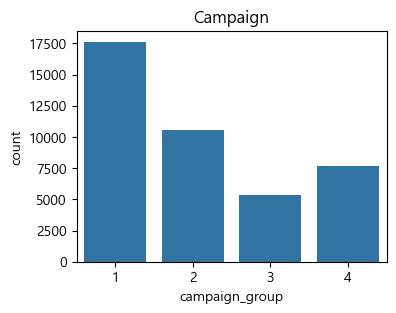

In [18]:
# 시각화

plt.figure(figsize=(4,3))
sns.countplot(x=bank_df['campaign_group'])
plt.title('Campaign')
plt.xlabel('campaign_group')
plt.ylabel('count')
plt.show()

#### - pdays

In [19]:
# pdays 확인
bank_df['pdays'].value_counts()

pdays
999    39661
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: count, dtype: int64

In [20]:
# 연락을 안한 사람은 999로 표시되어 있어서 분리 시도

bank_df['pdays_contacted'] = (bank_df['pdays'] != 999).astype(int)
bank_df['pdays_count'] = bank_df['pdays'].replace(999, 0)

bank_df = bank_df.drop(columns=['pdays'])

bank_df[['pdays_contacted','pdays_count']]

,pdays_contacted,pdays_count
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
41183,0,0
41184,0,0
41185,0,0
41186,0,0


In [21]:
bank_df['pdays_contacted'].value_counts().sum()

np.int64(41176)

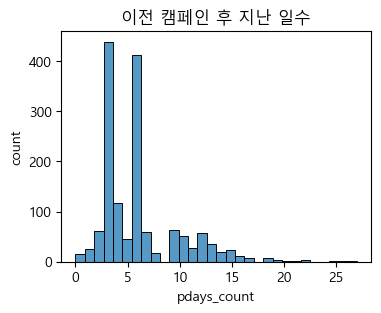

In [22]:
contacted_df = bank_df[bank_df['pdays_contacted'] == 1]

plt.figure(figsize=(4,3))
sns.histplot(contacted_df['pdays_count'], bins=30)
plt.title('이전 캠페인 후 지난 일수')
plt.xlabel('pdays_count')
plt.ylabel('count')
plt.show()


pday의 유효한 데이터도 로그변환 진행

In [23]:
# 연락을 한 사람들만 모아서 pdays_count 로그변환
bank_df['pdays_count_log'] = np.where(
    bank_df['pdays_contacted'] == 1,
    np.log1p(bank_df['pdays_count']),
    0
)

bank_df['pdays_count_log']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
41183    0.0
41184    0.0
41185    0.0
41186    0.0
41187    0.0
Name: pdays_count_log, Length: 41176, dtype: float64

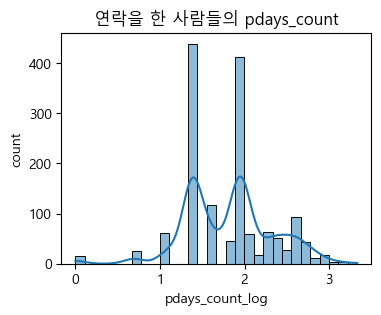

In [24]:
# 그래프 확인

contacted_df = bank_df[bank_df['pdays_contacted'] == 1]

plt.figure(figsize=(4,3))
sns.histplot(contacted_df['pdays_count_log'], bins=30, kde=True)
plt.title('연락을 한 사람들의 pdays_count')
plt.xlabel('pdays_count_log')
plt.ylabel('count')
plt.show()

#### - previous

In [25]:
# 고유값 확인
bank_df['previous'].value_counts()

previous
0    35551
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: count, dtype: int64

In [26]:
# 가입여부와 이전 연락 횟수의 비율 확인
bank_df.groupby('previous')['y'].value_counts(normalize=True)

previous  y  
0         no     0.911676
          yes    0.088324
1         no     0.787985
          yes    0.212015
2         no     0.535809
          yes    0.464191
3         yes    0.592593
          no     0.407407
4         yes    0.542857
          no     0.457143
5         yes    0.722222
          no     0.277778
6         yes    0.600000
          no     0.400000
7         no     1.000000
Name: proportion, dtype: float64

In [27]:
# 컨택 유무로 이진화 진행
bank_df['previous_contacted'] = (bank_df['previous'] > 0).astype(int)

bank_df.groupby('previous_contacted')['y'].value_counts(normalize=True)

previous_contacted  y  
0                   no     0.911676
                    yes    0.088324
1                   no     0.733511
                    yes    0.266489
Name: proportion, dtype: float64

분포가 0에 몰려 있고 컨택 횟수별 가입률이 일정하지 않아, 횟수 대신 컨택 유무로 이진화 진행

#### - 지표 변수들

그외 emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed는

거시경제 지표 변수들은 통계 데이터이므로, 추가적인 처리나 변환 없이 그대로 사용.

## 5. 범주형 데이터

In [28]:
# 범주형 데이터 확인
cat_features = bank_df.select_dtypes(include='object').columns.drop('y')
cat_features

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [29]:
# 인코딩 진행

bank_df = pd.get_dummies(data=bank_df, columns=cat_features, drop_first=True)
bank_df

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_log,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,1,0,1.1,93.994,-36.4,4.857,5191.0,no,4.043051,...,True,False,False,False,True,False,False,False,True,False
1,57,1,0,1.1,93.994,-36.4,4.857,5191.0,no,4.060443,...,True,False,False,False,True,False,False,False,True,False
2,37,1,0,1.1,93.994,-36.4,4.857,5191.0,no,3.637586,...,True,False,False,False,True,False,False,False,True,False
3,40,1,0,1.1,93.994,-36.4,4.857,5191.0,no,3.713572,...,True,False,False,False,True,False,False,False,True,False
4,56,1,0,1.1,93.994,-36.4,4.857,5191.0,no,4.043051,...,True,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,1,0,-1.1,94.767,-50.8,1.028,4963.6,yes,4.304065,...,False,True,False,False,False,False,False,False,True,False
41184,46,1,0,-1.1,94.767,-50.8,1.028,4963.6,no,3.850148,...,False,True,False,False,False,False,False,False,True,False
41185,56,2,0,-1.1,94.767,-50.8,1.028,4963.6,no,4.043051,...,False,True,False,False,False,False,False,False,True,False
41186,44,1,0,-1.1,94.767,-50.8,1.028,4963.6,yes,3.806662,...,False,True,False,False,False,False,False,False,True,False


## 6. 목표 변수 이진화

In [30]:
# 목표변수 y 이진화 진행

bank_df['y'] = bank_df['y'].map({'no': 0, 'yes': 1})
print(bank_df['y'].value_counts())
print(bank_df['y'].value_counts(normalize=True))

y
0    36537
1     4639
Name: count, dtype: int64
y
0    0.887337
1    0.112663
Name: proportion, dtype: float64


목표 변수 불균형 확인 -> 학습 단계 전, 해결 예정

## 7. 학습 전 최종 확인

In [31]:
bank_df.head()

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_log,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,1,0,1.1,93.994,-36.4,4.857,5191.0,0,4.043051,...,True,False,False,False,True,False,False,False,True,False
1,57,1,0,1.1,93.994,-36.4,4.857,5191.0,0,4.060443,...,True,False,False,False,True,False,False,False,True,False
2,37,1,0,1.1,93.994,-36.4,4.857,5191.0,0,3.637586,...,True,False,False,False,True,False,False,False,True,False
3,40,1,0,1.1,93.994,-36.4,4.857,5191.0,0,3.713572,...,True,False,False,False,True,False,False,False,True,False
4,56,1,0,1.1,93.994,-36.4,4.857,5191.0,0,4.043051,...,True,False,False,False,True,False,False,False,True,False


In [32]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41176 non-null  int64  
 1   campaign                       41176 non-null  int64  
 2   previous                       41176 non-null  int64  
 3   emp.var.rate                   41176 non-null  float64
 4   cons.price.idx                 41176 non-null  float64
 5   cons.conf.idx                  41176 non-null  float64
 6   euribor3m                      41176 non-null  float64
 7   nr.employed                    41176 non-null  float64
 8   y                              41176 non-null  int64  
 9   age_log                        41176 non-null  float64
 10  campaign_group                 41176 non-null  int64  
 11  pdays_contacted                41176 non-null  int64  
 12  pdays_count                    41176 non-null  int6

# 2. 데이터 학습 및 최적화

## 1. 입력변수, 목표변수 나누기

In [33]:
y = bank_df['y']
X = bank_df.drop(columns=['y'])

print(X.shape)
print(y.shape)

(41176, 57)
(41176,)


## 2. train, valid, test set 나누기

In [34]:
# train 60 , valid 20, test 20 
X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.25,  random_state=6)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(24705, 57)
(8235, 57)
(8236, 57)
(24705,)
(8235,)
(8236,)


## 3. 목표 변수 불균형 해결 SMOTETomek 진행

In [35]:
smt = SMOTETomek(random_state=42)
X_smt, y_smt = smt.fit_resample(X_train, y_train)

print(X_smt.shape)
print(y_smt.shape)

(43738, 57)
(43738,)


모델 튜닝을 위해 학습 데이터(train)를 학습용(train)과 검증용(validation)으로 분리함.

비율을 유지하기 위해 stratify 옵션을 적용하였다.

이후 학습 데이터에만 SMOTETomek 기법을 적용하여 불균형을 방지함.

In [36]:
# 확인
print(y_train.value_counts(normalize=True) * 100)
print(y_smt.value_counts(normalize=True) * 100)

y
0    88.735074
1    11.264926
Name: proportion, dtype: float64
y
0    50.0
1    50.0
Name: proportion, dtype: float64


## 4. 선형 모델

### 1. 다중 선형 회귀

In [37]:
# 학습
model_lin = LinearRegression()
model_lin.fit(X_train, y_train)

# 예측
y_pred_lin = model_lin.predict(X_valid)
rmse_lin = root_mean_squared_error(y_valid, y_pred_lin)

print("Linear Regression")
print("RMSE:", rmse_lin)

Linear Regression
RMSE: 0.2771308715039072


### 2. Ridge

In [38]:
# 학습
ridge = Ridge(alpha=1.0, max_iter=2000)
ridge.fit(X_train, y_train)

# 예측
y_pred_ridge = ridge.predict(X_valid)
rmse_ridge = root_mean_squared_error(y_valid, y_pred_ridge)

print("Ridge Regression")
print(f"RMSE: {rmse_ridge}" )

Ridge Regression
RMSE: 0.2771372987720072


### 3. Lasso

In [39]:
# 학습
lasso = Lasso(alpha=1.0, max_iter=2000)
lasso.fit(X_train, y_train)

# 예측
y_pred_lasso = lasso.predict(X_valid)
rmse_lasso = root_mean_squared_error(y_valid, y_pred_lasso)

print("Lasso Regression")
print(f"RMSE: {rmse_lasso}")

Lasso Regression
RMSE: 0.2944398384471995


이 문제는 분류 문제이므로 RMSE는 분류 성능을 확인하기에는 제한적임.

선형 회귀는 단지 base 모델로 사용하여,

현재 목표 변수를 선형적으로 설명하는데 어려움이 있음을 확인하기 위한 목적임.

## 5. 비선형 모델

### 1. 다항 회귀

In [40]:
# 다항 변환
poly_transformer = PolynomialFeatures(2)

X_train_poly = poly_transformer.fit_transform(X_train)
X_valid_poly  = poly_transformer.transform(X_valid)

# 표준화
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_valid_poly_scaled = scaler.transform(X_valid_poly)

# 학습
model = LinearRegression()
model.fit(X_train_poly_scaled, y_train)

# 예측
y_valid_pred = model.predict(X_valid_poly_scaled)
rmse_poly = root_mean_squared_error(y_valid, y_valid_pred)

print('Polynomial Linear Regression')
print(f"RMSE: {rmse_poly:.4f}")

Polynomial Linear Regression
RMSE: 0.2992


### 2. 정규화

In [41]:
# 결과 보관용
results_L2 = []
results_L1 = []

#### 1. 다항회귀 + L2 정규화

In [42]:
# 변환과 표준화는 다항회귀 변수 이용

for a in [0.1, 1, 10, 50, 100]:

    # Ridge 모델 
    ridge_model = Ridge(alpha=a, max_iter=5000)
    ridge_model.fit(X_train_poly_scaled, y_train)

    # 예측
    y_train_pred_L2 = ridge_model.predict(X_train_poly_scaled)
    y_valid_pred_L2 = ridge_model.predict(X_valid_poly_scaled)

    # RMSLE 계산
    train_rmse_L2 = root_mean_squared_error(y_train, y_train_pred_L2)
    valid_rmse_L2 = root_mean_squared_error(y_valid, y_valid_pred_L2)

    # 결과 저장
    results_L2.append({
        'degree': 2,
        'alpha': a,
        'train_rmse': train_rmse_L2,
        'valid_rmse': valid_rmse_L2
    })

    print(f'차수=2, 알파={a}, train={train_rmse_L2:.4f}, valid={valid_rmse_L2:.4f}')


차수=2, 알파=0.1, train=0.2651, valid=0.2970
차수=2, 알파=1, train=0.2657, valid=0.2956
차수=2, 알파=10, train=0.2665, valid=0.2918
차수=2, 알파=50, train=0.2674, valid=0.2889
차수=2, 알파=100, train=0.2679, valid=0.2878


#### 2. 다항회귀 + L1 정규화

In [43]:
# 변환과 표준화는 다항회귀 변수 이용

for a in [1, 10, 50, 100]:

    # Lasso 모델 (L1)
    lasso_model = Lasso(alpha=a, max_iter=5000, tol=1e-2)
    lasso_model.fit(X_train_poly_scaled, y_train)

    # 예측
    y_train_pred_L1 = lasso_model.predict(X_train_poly_scaled)
    y_valid_pred_L1 = lasso_model.predict(X_valid_poly_scaled)

    # RMSLE 계산
    train_rmse_L1 = root_mean_squared_error(y_train, y_train_pred_L1)
    valid_rmse_L1 = root_mean_squared_error(y_valid, y_valid_pred_L1)

    results_L1.append({
        'degree': 2,
        'alpha': a,
        'train_rmse': train_rmse_L1,
        'valid_rmse': valid_rmse_L1
    })

    print(f'차수=2, 알파={a}, train={train_rmse_L1:.4f}, valid={valid_rmse_L1:.4f}')

차수=2, 알파=1, train=0.3162, valid=0.3162
차수=2, 알파=10, train=0.3162, valid=0.3162
차수=2, 알파=50, train=0.3162, valid=0.3162
차수=2, 알파=100, train=0.3162, valid=0.3162


이번 미션은 분류 문제이므로, 선형 회귀와 다항 회귀 결과는 참고용으로만 확인하였다.

### 3. 로지스틱 회귀

Train ACC: 0.8732
Valid ACC: 0.8519
ROC-AUC  : 0.7331


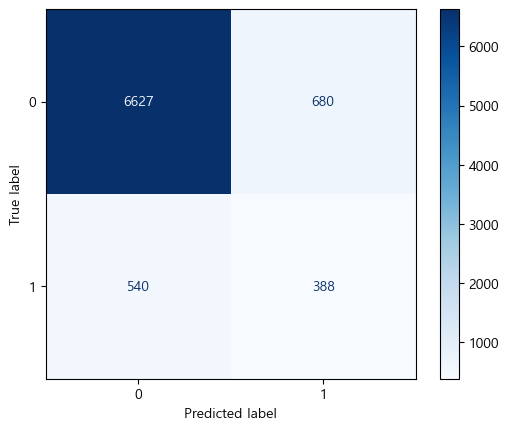

In [44]:
# 1. 표준화
scaler = StandardScaler()
X_smt_scaled = scaler.fit_transform(X_smt)
X_valid_scaled = scaler.transform(X_valid)

# 2. 로지스틱 회귀
log_model = LogisticRegression(solver='saga', max_iter=5000)
log_model.fit(X_smt_scaled, y_smt)

# 3. 예측
y_train_pred_R = log_model.predict(X_smt_scaled)
y_valid_pred_R = log_model.predict(X_valid_scaled)

y_valid_proba_R = log_model.predict_proba(X_valid_scaled)[:, 1]

# 4. 평가
train_R_acc = accuracy_score(y_smt, y_train_pred_R)
valid_R_acc = accuracy_score(y_valid, y_valid_pred_R)
roc_R_auc = roc_auc_score(y_valid, y_valid_proba_R)

print(f"Train ACC: {train_R_acc:.4f}")
print(f"Valid ACC: {valid_R_acc:.4f}")
print(f"ROC-AUC  : {roc_R_auc:.4f}")

cm_R = confusion_matrix(y_valid, y_valid_pred_R)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_R, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.show()

로지스틱 회귀 모델을 베이스라인 모델로 설정.

이를 통해 트리 기반 모델과의 성능 비교 예정.

## 6. 트리 계열

### 1. 결정트리

In [45]:
for depth in [3, 5, 7]:
    
    # 결정 트리 학습
    dt_model = DecisionTreeClassifier(
        max_depth=depth,
        min_samples_leaf=20,
        random_state=42
    )
    
    dt_model.fit(X_smt, y_smt)
    
    # 예측
    y_pred_dt = dt_model.predict(X_valid)
    y_proba_dt = dt_model.predict_proba(X_valid)[:, 1]
    
    acc = accuracy_score(y_valid, y_pred_dt)
    auc = roc_auc_score(y_valid, y_proba_dt)
    
    print(f"DT : depth={depth}, ACC={acc:.4f}, AUC={auc:.4f}")


DT : depth=3, ACC=0.8402, AUC=0.7580
DT : depth=5, ACC=0.8697, AUC=0.7674
DT : depth=7, ACC=0.8789, AUC=0.7536


### 2. 랜덤 포레스트

In [46]:
for depth in [5, 10, 15]:
    for leaf in [10, 20]:

        # 랜덤 포레스트 학습
        rf_model = RandomForestClassifier(
            n_estimators=300,
            max_depth=depth,
            min_samples_leaf=leaf,
            n_jobs=1,
            random_state=42
        )
    
        rf_model.fit(X_smt, y_smt)
        
        # 예측
        y_pred_rf = rf_model.predict(X_valid)
        y_proba_rf = rf_model.predict_proba(X_valid)[:, 1]
        
        acc = accuracy_score(y_valid, y_pred_rf)
        auc = roc_auc_score(y_valid, y_proba_rf)
        
        print(f"RF : depth={depth}, leaf={leaf}, ACC={acc:.4f}, AUC={auc:.4f}")

RF : depth=5, leaf=10, ACC=0.8282, AUC=0.7889
RF : depth=5, leaf=20, ACC=0.8288, AUC=0.7890
RF : depth=10, leaf=10, ACC=0.8681, AUC=0.7933
RF : depth=10, leaf=20, ACC=0.8662, AUC=0.7938
RF : depth=15, leaf=10, ACC=0.8766, AUC=0.7918
RF : depth=15, leaf=20, ACC=0.8703, AUC=0.7933


### 3. XGBoost

XGB ACC : 0.8934
XGB AUC : 0.7833


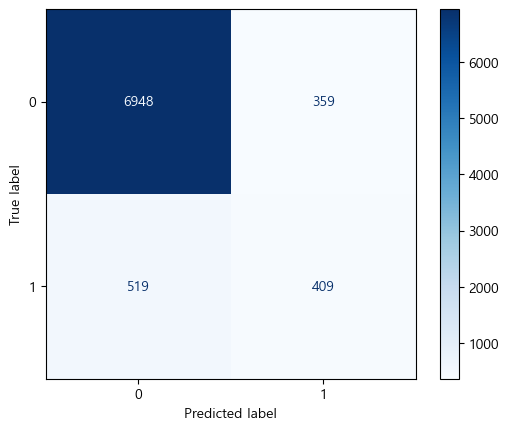

In [47]:
# XGBoost 모델
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

# 학습 
xgb_model.fit(X_smt, y_smt)

# 예측
y_pred_xgb = xgb_model.predict(X_valid)
y_proba_xgb = xgb_model.predict_proba(X_valid)[:, 1]

# 평가
xgb_acc = accuracy_score(y_valid, y_pred_xgb)
xgb_auc = roc_auc_score(y_valid, y_proba_xgb)

print(f"XGB ACC : {xgb_acc:.4f}")
print(f"XGB AUC : {xgb_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_valid, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.show()

### 4. CatBoost

CB ACC : 0.8969
CB AUC : 0.7875


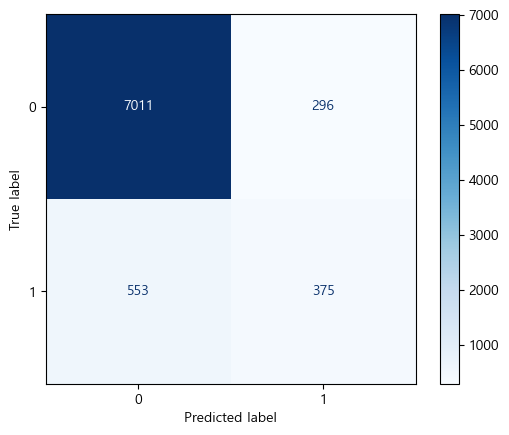

In [48]:
# CatBoost 모델
cb_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    verbose=0,
    random_state=42
)

# 학습
cb_model.fit(X_smt, y_smt)

# 예측
y_pred_cb = cb_model.predict(X_valid)
y_proba_cb = cb_model.predict_proba(X_valid)[:, 1]

# 평가
cb_acc = accuracy_score(y_valid, y_pred_cb)
cb_auc = roc_auc_score(y_valid, y_proba_cb)

print(f"CB ACC : {cb_acc:.4f}")
print(f"CB AUC : {cb_auc:.4f}")

# Confusion Matrix
cm_cb = confusion_matrix(y_valid, y_pred_cb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cb, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.show()

### 5. LGBM

LGBM ACC : 0.8973
LGBM AUC : 0.7859


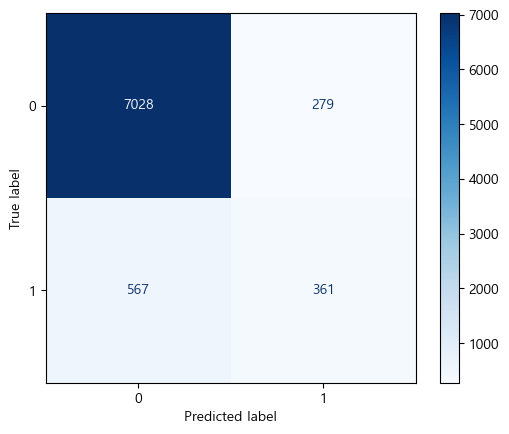

In [49]:
# LGBM 모델
lgb_model = LGBMClassifier(
    verbosity=-1,
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 학습 
lgb_model.fit(X_smt, y_smt)

# 예측
y_pred_lgb = lgb_model.predict(X_valid)
y_proba_lgb = lgb_model.predict_proba(X_valid)[:, 1]

# 평가
lgbm_acc = accuracy_score(y_valid, y_pred_lgb)
lgbm_auc = roc_auc_score(y_valid, y_proba_lgb)

print(f"LGBM ACC : {lgbm_acc:.4f}")
print(f"LGBM AUC : {lgbm_auc:.4f}")

# Confusion Matrix
cm_lgb = confusion_matrix(y_valid, y_pred_lgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgb, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.show()

## 7. 하이퍼 파라미터 튜닝 (Optuna - create_study)

### 1. Decision Tree 튜닝

In [50]:
def objective_dt(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
        "random_state": 42
    }

    model = DecisionTreeClassifier(**params)
    model.fit(X_smt, y_smt)

    y_val_proba = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_val_proba)

    return auc


study_dt = optuna.create_study(direction="maximize", study_name="DT_AUC")
study_dt.optimize(objective_dt, n_trials=30)

print("DT Best AUC:", study_dt.best_value)
print("DT Best Params:", study_dt.best_params)

[I 2026-01-22 13:41:03,425] A new study created in memory with name: DT_AUC
[I 2026-01-22 13:41:03,666] Trial 0 finished with value: 0.7548674245999349 and parameters: {'max_depth': 12, 'min_samples_leaf': 40, 'min_samples_split': 15}. Best is trial 0 with value: 0.7548674245999349.
[I 2026-01-22 13:41:03,890] Trial 1 finished with value: 0.7492517213064468 and parameters: {'max_depth': 10, 'min_samples_leaf': 19, 'min_samples_split': 19}. Best is trial 0 with value: 0.7548674245999349.
[I 2026-01-22 13:41:03,996] Trial 2 finished with value: 0.7539918028531922 and parameters: {'max_depth': 4, 'min_samples_leaf': 22, 'min_samples_split': 7}. Best is trial 0 with value: 0.7548674245999349.
[I 2026-01-22 13:41:04,220] Trial 3 finished with value: 0.7350451179313177 and parameters: {'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 5}. Best is trial 0 with value: 0.7548674245999349.
[I 2026-01-22 13:41:04,353] Trial 4 finished with value: 0.7675586677630802 and parameters: {'ma

DT Best AUC: 0.7675586677630802
DT Best Params: {'max_depth': 5, 'min_samples_leaf': 11, 'min_samples_split': 26}


### 2. Random Forest 튜닝

In [51]:
def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
        "max_features": trial.suggest_categorical(
            "max_features", ["sqrt", "log2"]
        ),
        "n_jobs": 1,
        "random_state": 42
    }

    model = RandomForestClassifier(**params)
    model.fit(X_smt, y_smt)

    y_val_proba = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_val_proba)

    return auc


study_rf = optuna.create_study(direction="maximize", study_name="RF_AUC")
study_rf.optimize(objective_rf, n_trials=30)

print("RF Best AUC:", study_rf.best_value)
print("RF Best Params:", study_rf.best_params)

[I 2026-01-22 13:41:08,142] A new study created in memory with name: RF_AUC
[I 2026-01-22 13:41:17,424] Trial 0 finished with value: 0.7926666328461608 and parameters: {'n_estimators': 594, 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 15, 'max_features': 'log2'}. Best is trial 0 with value: 0.7926666328461608.
[I 2026-01-22 13:41:22,671] Trial 1 finished with value: 0.7931033008027257 and parameters: {'n_estimators': 205, 'max_depth': 13, 'min_samples_leaf': 30, 'min_samples_split': 47, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7931033008027257.
[I 2026-01-22 13:41:36,938] Trial 2 finished with value: 0.7925088365903267 and parameters: {'n_estimators': 519, 'max_depth': 19, 'min_samples_leaf': 28, 'min_samples_split': 39, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7931033008027257.
[I 2026-01-22 13:41:43,249] Trial 3 finished with value: 0.7916017293289854 and parameters: {'n_estimators': 232, 'max_depth': 15, 'min_samples_leaf': 27, 'min_sample

RF Best AUC: 0.7944087330051958
RF Best Params: {'n_estimators': 591, 'max_depth': 10, 'min_samples_leaf': 14, 'min_samples_split': 6, 'max_features': 'log2'}


### 3. XGBoost 튜닝

In [52]:
def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "eval_metric": "logloss",
        "random_state": 42
    }

    model = XGBClassifier(**params)
    model.fit(X_smt, y_smt)

    y_val_proba = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_val_proba)

study_xgb = optuna.create_study(direction="maximize", study_name="XGB_AUC")
study_xgb.optimize(objective_xgb, n_trials=30)

print("XGB Best AUC:", study_xgb.best_value)
print("XGB Best Params:", study_xgb.best_params)

[I 2026-01-22 13:45:46,137] A new study created in memory with name: XGB_AUC
[I 2026-01-22 13:45:47,240] Trial 0 finished with value: 0.7805068828662172 and parameters: {'n_estimators': 444, 'max_depth': 4, 'learning_rate': 0.12869742086676947, 'subsample': 0.6529998097805857, 'colsample_bytree': 0.782312062406318}. Best is trial 0 with value: 0.7805068828662172.
[I 2026-01-22 13:45:48,628] Trial 1 finished with value: 0.7832375691943956 and parameters: {'n_estimators': 451, 'max_depth': 5, 'learning_rate': 0.012731541785194724, 'subsample': 0.798875189388483, 'colsample_bytree': 0.9242128767152703}. Best is trial 1 with value: 0.7832375691943956.
[I 2026-01-22 13:45:49,577] Trial 2 finished with value: 0.7838259132716385 and parameters: {'n_estimators': 302, 'max_depth': 5, 'learning_rate': 0.014243583262956962, 'subsample': 0.9510206616495741, 'colsample_bytree': 0.6648806748051619}. Best is trial 2 with value: 0.7838259132716385.
[I 2026-01-22 13:45:50,979] Trial 3 finished with val

XGB Best AUC: 0.7870374357607017
XGB Best Params: {'n_estimators': 338, 'max_depth': 8, 'learning_rate': 0.010094708229066447, 'subsample': 0.626798348716808, 'colsample_bytree': 0.6832818662771184}


### 4. CatBoost 튜닝

In [53]:
def objective_cb(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 300, 700),
        "depth": trial.suggest_int("depth", 4, 6),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "loss_function": "Logloss",
        "verbose": 0,
        "random_state": 42
    }

    model = CatBoostClassifier(**params)
    model.fit(
        X_smt, y_smt,
        eval_set=(X_valid, y_valid),
        early_stopping_rounds=50,
        verbose=0)

    y_val_proba = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_val_proba)

study_cb = optuna.create_study(direction="maximize", study_name="CB_AUC")
study_cb.optimize(objective_cb, n_trials=20)

print("CB Best AUC:", study_cb.best_value)
print("CB Best Params:", study_cb.best_params)


[I 2026-01-22 13:46:27,289] A new study created in memory with name: CB_AUC
[I 2026-01-22 13:46:36,602] Trial 0 finished with value: 0.7874367192772165 and parameters: {'iterations': 452, 'depth': 4, 'learning_rate': 0.01616366164291634}. Best is trial 0 with value: 0.7874367192772165.
[I 2026-01-22 13:46:47,725] Trial 1 finished with value: 0.790055915914357 and parameters: {'iterations': 525, 'depth': 5, 'learning_rate': 0.03313358935661278}. Best is trial 1 with value: 0.790055915914357.
[I 2026-01-22 13:46:54,781] Trial 2 finished with value: 0.78684055912375 and parameters: {'iterations': 304, 'depth': 6, 'learning_rate': 0.010161170032587562}. Best is trial 1 with value: 0.790055915914357.
[I 2026-01-22 13:47:07,974] Trial 3 finished with value: 0.7846846493442754 and parameters: {'iterations': 638, 'depth': 6, 'learning_rate': 0.08990036428597031}. Best is trial 1 with value: 0.790055915914357.
[I 2026-01-22 13:47:17,157] Trial 4 finished with value: 0.7883570991208242 and param

CB Best AUC: 0.7910076337994272
CB Best Params: {'iterations': 576, 'depth': 4, 'learning_rate': 0.025981586629378245}


### 5. LGBM 튜닝

In [54]:
def objective_lgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 800),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 64),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "random_state": 42
    }

    model = LGBMClassifier(**params)
    model.fit(X_smt, y_smt)

    y_val_proba = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_val_proba)

study_lgb = optuna.create_study(direction="maximize", study_name="LGBM_AUC")
study_lgb.optimize(objective_lgb, n_trials=50)

print("LGBM Best AUC:", study_lgb.best_value)
print("LGBM Best Params:", study_lgb.best_params)

[I 2026-01-22 13:50:00,351] A new study created in memory with name: LGBM_AUC
[I 2026-01-22 13:50:01,996] Trial 0 finished with value: 0.7705043699239746 and parameters: {'n_estimators': 778, 'learning_rate': 0.12974565620979606, 'num_leaves': 21, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.602148760051928, 'colsample_bytree': 0.6111936100949327}. Best is trial 0 with value: 0.7705043699239746.
[I 2026-01-22 13:50:02,625] Trial 1 finished with value: 0.7862671835698409 and parameters: {'n_estimators': 511, 'learning_rate': 0.13576190717128608, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 11, 'subsample': 0.9445575373579522, 'colsample_bytree': 0.716196095032141}. Best is trial 1 with value: 0.7862671835698409.
[I 2026-01-22 13:50:04,626] Trial 2 finished with value: 0.7772059916565598 and parameters: {'n_estimators': 717, 'learning_rate': 0.04072792114663302, 'num_leaves': 57, 'max_depth': 9, 'min_child_samples': 43, 'subsample': 0.9110772586509984, 'colsample_byt

LGBM Best AUC: 0.7896683565121777
LGBM Best Params: {'n_estimators': 525, 'learning_rate': 0.17278145859486568, 'num_leaves': 19, 'max_depth': 3, 'min_child_samples': 40, 'subsample': 0.8051165059583939, 'colsample_bytree': 0.8217954006939466}


# 3. 최종 모델 선정

In [55]:
result_df = pd.DataFrame([
    ("XGBoost", study_xgb.best_value),
    ("CatBoost", study_cb.best_value),
    ("LGBM", study_lgb.best_value),
    ("RandomForest", study_rf.best_value),
    ("DecisionTree", study_dt.best_value),
    ("LogisticRegression", roc_R_auc)
], columns=["Model", "ROC_AUC"])

result_df = (
    result_df
    .sort_values("ROC_AUC", ascending=False)
    .reset_index(drop=True)
)

result_df

,Model,ROC_AUC
0,RandomForest,0.794409
1,CatBoost,0.791008
2,LGBM,0.789668
3,XGBoost,0.787037
4,DecisionTree,0.767559
5,LogisticRegression,0.733074


결과 

Optuna를 통해 각 모델의 하이퍼파라미터 튜닝을 하고,

최적의 ROC-AUC 값을 기준으로 모델 성능을 비교함.

그 결과 RandomForest 모델이 가장 높은 성능을 보여 최종 선정함.

## - 최종 학습

In [56]:
#  train + valid 합치기
X_final = pd.concat([X_train, X_valid])
y_final = pd.concat([y_train, y_valid])

# SMOTETomek (최종 학습 데이터에만 적용)
smt = SMOTETomek(random_state=42)
X_final_smt, y_final_smt = smt.fit_resample(X_final, y_final)

#  최종 모델 
final_model = RandomForestClassifier(
    **study_rf.best_params,   
    class_weight="balanced",
    random_state=42,
    n_jobs=1
)

#  최종 학습
final_model.fit(X_final_smt, y_final_smt)

# test
final_y_test_proba = final_model.predict_proba(X_test)[:, 1]
final_test_auc = roc_auc_score(y_test, final_y_test_proba)

print(f"최종 Test ROC-AUC = {final_test_auc:.6f}")

print("음수 개수:", (final_y_test_proba < 0).sum())
print("NaN 개수:", np.isnan(final_y_test_proba).sum())
print("inf 개수:", np.isinf(final_y_test_proba).sum())

최종 Test ROC-AUC = 0.792066
음수 개수: 0
NaN 개수: 0
inf 개수: 0


불균형 문제를 완화하기 위해

학습 데이터(train+validation)에 한하여 SMOTETomek을 적용하였고,

RandomForest 모델 학습시 class_weight="balanced"를 사용하여

소수 클래스에 대한 학습 비중을 추가로 조정함.

## - 속성 중요도

In [57]:
# 속성 중요도

feature_importance = pd.DataFrame({
    "feature": X_final.columns,
    "importance": final_model.feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importance.head()

,feature,importance
7,nr.employed,0.132736
6,euribor3m,0.131944
3,emp.var.rate,0.108319
5,cons.conf.idx,0.066349
4,cons.price.idx,0.051416


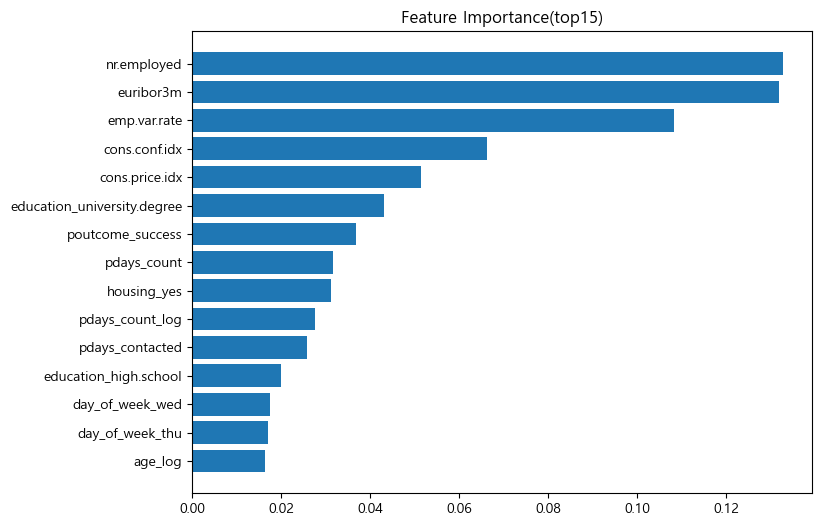

In [58]:
# 시각화

plt.figure(figsize=(8, 6))
plt.barh(feature_importance['feature'][:15][::-1],
         feature_importance['importance'][:15][::-1])
plt.title('Feature Importance(top15)')
plt.show()

## - 지표 확인

In [59]:
# 이진 분류
final_y_test_pred = (final_y_test_proba >= 0.5).astype(int)

# 지표 계산
precision = precision_score(y_test, final_y_test_pred)
recall = recall_score(y_test, final_y_test_pred)
f1 = f1_score(y_test, final_y_test_pred)

print(classification_report(y_test, final_y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      7308
           1       0.41      0.60      0.49       928

    accuracy                           0.86      8236
   macro avg       0.68      0.74      0.70      8236
weighted avg       0.89      0.86      0.87      8236



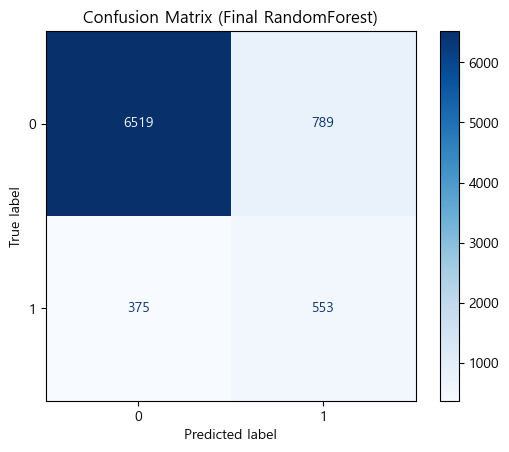

In [60]:
# 혼동행렬 계산
cm = confusion_matrix(y_test, final_y_test_pred)

# 시각화
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[0, 1]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Final RandomForest)")
plt.show()

최종 선정된 Random Forest 모델로 train 데이터와 validation 데이터 합친 후 학습하여,

속성 중요도를 통하여 확인하였음.

# 4. 데이터 분석

## 1. 분석용 데이터 준비

In [61]:
# 분석용 데이터 준비
analysis_df = X_test.copy()
analysis_df["subscribed"] = y_test.values
analysis_df.head()

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,age_log,campaign_group,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,subscribed
21019,47,4,0,1.4,93.444,-36.1,4.964,5228.1,3.871201,4,...,False,False,False,False,True,False,False,True,False,0
37867,40,3,0,-2.9,92.201,-31.4,0.821,5076.2,3.713572,3,...,False,False,False,True,False,False,False,True,False,0
32779,38,1,0,-1.8,92.893,-46.2,1.299,5099.1,3.663562,1,...,False,False,False,True,False,False,False,True,False,0
34778,25,6,1,-1.8,92.893,-46.2,1.266,5099.1,3.258097,4,...,False,False,False,False,True,False,False,False,False,0
9203,38,4,0,1.4,94.465,-41.8,4.967,5228.1,3.663562,4,...,False,False,False,False,False,False,False,True,False,1


In [62]:
# 분석용 데이터 확인

analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8236 entries, 21019 to 21513
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            8236 non-null   int64  
 1   campaign                       8236 non-null   int64  
 2   previous                       8236 non-null   int64  
 3   emp.var.rate                   8236 non-null   float64
 4   cons.price.idx                 8236 non-null   float64
 5   cons.conf.idx                  8236 non-null   float64
 6   euribor3m                      8236 non-null   float64
 7   nr.employed                    8236 non-null   float64
 8   age_log                        8236 non-null   float64
 9   campaign_group                 8236 non-null   int64  
 10  pdays_contacted                8236 non-null   int64  
 11  pdays_count                    8236 non-null   int64  
 12  pdays_count_log                8236 non-null   f

In [63]:
# 분석용 데이터 확인

analysis_df.describe(include='all')

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,age_log,campaign_group,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,subscribed
count,8236.000000,8236.000000,8236.000000,8236.000000,8236.000000,8236.000000,8236.000000,8236.000000,8236.000000,8236.000000,...,8236,8236,8236,8236,8236,8236,8236,8236,8236,8236.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,2,2,2,2,2,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,True,False,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7404,8100,8117,6534,6535,6634,6594,7162,7983,NaN
mean,39.803667,2.555610,0.161608,0.098118,93.575510,-40.479492,3.639114,5168.052052,3.678058,2.063623,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.112676
std,10.373870,2.799374,0.469585,1.564064,0.578257,4.619177,1.726517,71.701014,0.246222,1.135435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.316216
min,17.000000,1.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000,2.890372,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,32.000000,1.000000,0.000000,-1.800000,93.075000,-42.700000,1.354000,5099.100000,3.496508,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,38.000000,2.000000,0.000000,1.100000,93.444000,-41.800000,4.857000,5191.000000,3.663562,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,47.000000,3.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,3.871201,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


## 2. 상위 속성 중요도 확인

In [64]:
# 속성 중요도 확인
feature_importance.head(10)

,feature,importance
7,nr.employed,0.132736
6,euribor3m,0.131944
3,emp.var.rate,0.108319
5,cons.conf.idx,0.066349
4,cons.price.idx,0.051416
33,education_university.degree,0.043139
56,poutcome_success,0.036751
11,pdays_count,0.031739
38,housing_yes,0.031280
12,pdays_count_log,0.027673


In [65]:
# 속성 중요도 탑5 뽑기

top_features = feature_importance["feature"].head(5).tolist()
top_features

['nr.employed', 'euribor3m', 'emp.var.rate', 'cons.conf.idx', 'cons.price.idx']

In [66]:
# 속성 중요도 탑5 기본 정보

analysis_df[top_features].describe()

,nr.employed,euribor3m,emp.var.rate,cons.conf.idx,cons.price.idx
count,8236.000000,8236.000000,8236.000000,8236.000000,8236.000000
mean,5168.052052,3.639114,0.098118,-40.479492,93.575510
std,71.701014,1.726517,1.564064,4.619177,0.578257
min,4963.600000,0.635000,-3.400000,-50.800000,92.201000
25%,5099.100000,1.354000,-1.800000,-42.700000,93.075000
50%,5191.000000,4.857000,1.100000,-41.800000,93.444000
75%,5228.100000,4.961000,1.400000,-36.400000,93.994000
max,5228.100000,5.045000,1.400000,-26.900000,94.767000


In [67]:
# 가입 여부별 평균 비교
analysis_df.groupby("subscribed")[top_features].mean().T

subscribed,0,1
nr.employed,5177.133347,5096.536853
euribor3m,3.829218,2.142044
emp.var.rate,0.265285,-1.218319
cons.conf.idx,-40.559852,-39.846659
cons.price.idx,93.604720,93.345483


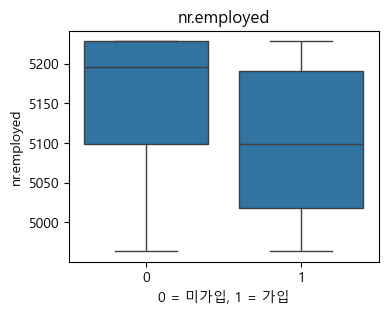

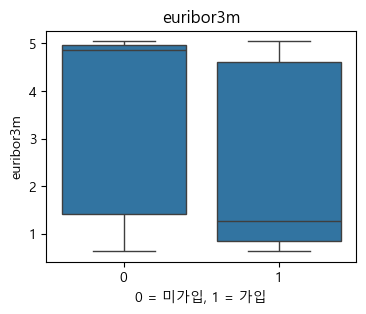

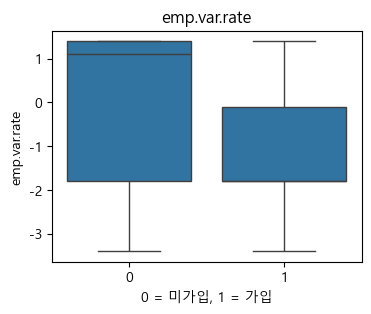

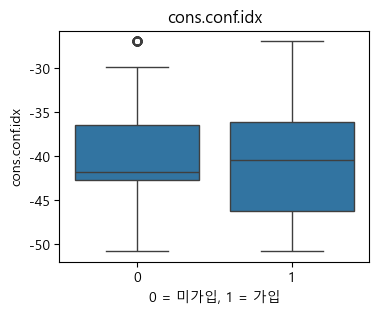

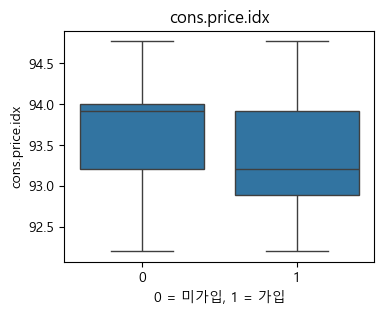

In [68]:
# 시각화: 가입 여부에 따른 분포 비교
for col in top_features:
    plt.figure(figsize=(4, 3))
    sns.boxplot(
        data=analysis_df,
        x="subscribed",
        y=col
    )
    plt.xlabel("0 = 미가입, 1 = 가입")
    plt.title(col)
    plt.show()

**euribor3m (금리)**

미가입(0): 값이 전반적으로 높음 / 가입(1): 낮은 구간에 몰림

-> 금리가 낮을수록 가입 확률이 높음


**nr.employed (고용자 수)**

미가입(0): 중앙값이 더 높음 / 가입(1): 전반적으로 낮은 수준

-> 고용 규모가 줄어든 시기에 가입이 더 많음

**emp.var.rate (고용 변화율)**

미가입(0): 양수(경기 확장) 쪽에 치우침 / 가입(1): 음수(경기 둔화) 쪽에 분포

-> 경기 둔화 국면에서 가입 증가

**cons.conf.idx (소비자 신뢰지수)** 

두 그룹 모두 음수지만 가입(1) 쪽이 더 낮고 분산 큼

-> 소비 심리가 나쁠수록 가입 경향

**cons.price.idx (물가지수)**

미가입(0): 약간 높음 / 가입(1): 조금 낮음

-> 물가가 낮은 시기에 가입이 더 많음 (차이는 크지 않음)

속성 중요도 상위 변수들을 분석한 결과,

가입 여부는 개인적 특성(나이, 학력, 결혼 여부 등)보다 당시의 경제 지표(금리, 고용 수준, 소비 심리)에 큰 영향을 받는다.

-> 정기예금 상품이 경제에 민감한 상품일 수 있다.

## 3. 경제와 관련한 속성 만들기

In [69]:
# 경제 지수 만들기
analysis_df["econ_score"] = analysis_df[top_features].mean(axis=1)
analysis_df[["econ_score"]].head()

,econ_score
21019,1058.3616
37867,1026.9844
32779,1029.0584
34778,1029.0518
9203,1057.4264


구간화를 진행하면서 표본수 차이로 생기는 왜곡을 줄이기 위해 qcut을 사용

In [70]:
# 구간화
analysis_df["econ_group"] = pd.qcut(
    analysis_df["econ_score"],
    q=3,
    labels=["Bad", "Normal", "Good"]
)

analysis_df["econ_group"].value_counts(normalize=True)

econ_group
Normal    0.369475
Bad       0.340821
Good      0.289704
Name: proportion, dtype: float64

In [71]:
# 구간별 평균
analysis_df.groupby("econ_group",observed=True)["subscribed"].mean()

econ_group
Bad       0.238333
Normal    0.046007
Good      0.049874
Name: subscribed, dtype: float64

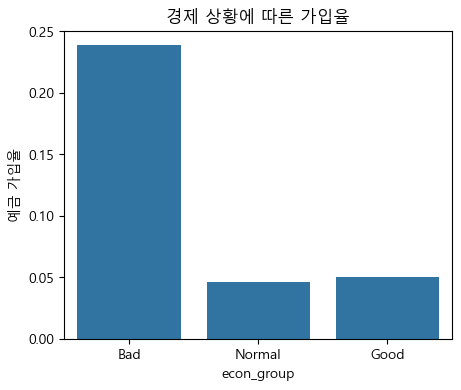

In [72]:
# 시각화

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.barplot(
    data=analysis_df,
    x="econ_group",
    y="subscribed",
    estimator="mean",
    errorbar=None
)
plt.ylabel("예금 가입율")
plt.title("경제 상황에 따른 가입율")
plt.show()


## 4. 성능 전후 비교

In [73]:
# 경제 지표를 추가한 속성으로 성능 전후 비교

# 최종 모델 train, test 데이터 가져오기
X_final_vs = X_final.copy()
X_test_vs = X_test.copy()

# 경제 지수 속성 추가하기
X_final_vs["econ_score"] = X_final_vs[top_features].mean(axis=1)
X_test_vs["econ_score"] = X_test_vs[top_features].mean(axis=1)

# 불균형 해결
smt = SMOTETomek(random_state=42)
X_final_fe_smt, y_final_fe_smt = smt.fit_resample(X_final_vs, y_final)

In [74]:
# 같은 조건으로 학습하기
model_vs = RandomForestClassifier(
    **study_rf.best_params,
    class_weight="balanced",
    random_state=42,
    n_jobs=1
)

model_vs.fit(X_final_fe_smt, y_final_fe_smt)

y_test_proba_vs = model_vs.predict_proba(X_test_vs)[:, 1]
auc_vs = roc_auc_score(y_test, y_test_proba_vs)

auc_vs

0.7937357265538003

In [75]:
# 성능 비교
pd.DataFrame({
    "Model": ["처음 모델", "추가 학습한 모델"],
    "ROC_AUC": [round(final_test_auc,4), round(auc_vs,4)]
})

,Model,ROC_AUC
0,처음 모델,0.7921
1,추가 학습한 모델,0.7937


속성중요도를 통해 경제 지표들이 정기예금 가입 여부에 중요한 영향을 미친다는 점을 확인하였다.

이를 하나의 경제 지수(econ_score)로 결합하여, 추가 변수를 생성한 결과,

ROC_AUC가 **0.7921에서 0.7937로 향상**되었다.

이는 데이터 분석을 통해 나온 결과가 실제 예측 성능 향상으로 이어질 수 있음을 보여준다.

기존 RandomForest 모델이 이미 비선형 관계를 잘 학습하고 있었기 때문에

하나의 변수 추가로 성능의 큰 변화는 기대하기는 어려웠다.

그럼에도 동일 조건에서 성능이 개선되었다는 점에 의미가 있다.

# 5. 결론

---

이번 미션은 예금 가입 여부를 분류하는 모델을 학습하고 그 모델을 통해 도출한 인사이트를 바탕으로 비즈니스 전략을 제시하는 것이다.

---

최적의 모델을 찾기 위하여 베이스라인을 **로지스틱 회귀** 로 하고,

결정 트리, 랜덤 포레스트, XGBoost, CatBoost, LGBM의 하이퍼 파라미터 튜닝(optuna)을 진행하였고,

그 결과, 랜덤 포레스트가 비교 지표인 ROC_AUC의 결과가 높게 나와서, **랜덤 포레스트로 최종 선정** 하였다.

---

이후, 속성 중요도를 확인하고 상위 5개에 대하여 확인한 결과

개인 특성(나이, 학력, 결혼 여부 등)보다 경제 지표(금리, 고용 수준, 소비 심리)에 큰 영향을 받는 것을 확인했다.

이에 경제 지수의 새로운 속성을 만들어서, 동일한 조건에서 비교한 결과, **0.7929에서 0.7939로 성능이 개선**되었다.

---

비즈니스 전략은 경제에 따른 마케팅을 목표로 하는 것이 예금 가입 여부를 향상시킬 것으로 보인다.

---


**전략 1. 마케팅 타이밍 최적화**

금리,고용,소비 심리 지표가 나빠지는 시점에 정기예금 캠페인을 운영

-> 동일 비용 대비 가입률 상승

**전략 2. 개인 특성보다 경제 기반으로 상품 설계**

고객을 분석하고 세분화하기 보다 경제 신호를 기반으로 상품을 설계

-> 같은 인력 대비 가입률 상승

**전략 3. 광고 비용 절감**

경제가 좋은 시기에는 공격적 정기예금 마케팅을 최소화하여 비용을 절감

-> 비용 절감

**전략 4. 인력 운영 최적화**

경제가 안좋아지는 시기에 상담 인력 집중 배치

경제가 좋아지는 시기에는 자동화 채널 중심 운영

-> 비용 절감